# EV Clustering

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from IMPORT_DATAFRAME_JSON_HDF5 import *
import seaborn as sns
import matplotlib.pyplot as plt

## Import jsons/hdf5

Data time window: 02.03.2017 - 28.04.2017

In [ ]:
data = import_trasient_from_file("jsons/")
data = map_transients_to_PQ_data(data, "HDF5", 20, ['P'])

## Explore the data

This chapter should give a overview of the used dataset. Therefore step one is to study the header of the dataset. Here the column *'begin_timestamp_float'* can be used as a index, make our're events easier to find and to compare with other data sources. 

In [ ]:
length = len(data)
print("Number of data points: {}".format(length))
data.head(1)

In [ ]:
transient_overview = pd.read_csv('transientlist.csv', sep=',', header=None)
transient_overview[0] = transient_overview[0].apply(convert_to_datetime)
len(transient_overview)

In [ ]:
transient_overview.sort_values(0).head(1)

In [ ]:
data.sort_values('begin_timestamp_string').head(1)

## Preprossing Data Seb

Combine transients data with power data.

In [ ]:
data['charging_status']=0
data['P_mean']=0
data['P_delta'] = 0
data['P_Plugin']=0
data['P_Unplug'] = 0
for row in range(0, len(data)):
    # Getting the mean power before during and after the timestamp (-T, T)
    # Defining charging_status as 1 for avg(P)>300W else 0 and writing it to a new column
    P_mean = sum(data.iloc[row]['P']) / float(len(data.iloc[row]['P']))
    data.set_value(data.index[row],'P_mean', P_mean)
    if P_mean>300:
        data.set_value(data.index[row],'charging_status',int(1))
    else:
       data.set_value(data.index[row],'charging_status', int(0))
     # Defining if a new car is plugged in during the appearance of the transient
    P_mean_before = sum((data.iloc[row]['P'])[:10]) / float(len((data.iloc[row]['P'])[:10])) 
    P_mean_after = sum((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):]) / float(len((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):])) 
    P_delta = P_mean_after - P_mean_before
    data.set_value(data.index[row],'P_delta',P_delta)
    if P_delta > 2000:
        data.set_value(data.index[row],'P_Plugin',int(1))
    elif P_delta < -2000:
        data.set_value(data.index[row],'P_Unplug',int(1))

In [ ]:
data.head()

## Preprossing Data

The next step is to Preprocessing the Data. In this present case it exist four different events to detect. At first transient cause from electric cars and the second on all from outside. In the following step all transients should be seperate in:

* ```events_from_outside```
* ```transients_1_phase```
* ```transients_2_phase```
* ```transients_3_phase```

This will be save into a pandas dataframe and export as a pkl file.

In [ ]:
%%time
from collections import Counter
#documentation : https://docs.python.org/2/library/collections.html

# put all timestamps to a list
# and create a dict with Counter() to get a timestamp as key and a value how often we can find this timestamp
timestamps = data.index.tolist()
counter_timestamps = Counter()
for timestamp in timestamps:
    counter_timestamps[timestamp] += 1

# create a series from the counter object, that we can handle better the information
counter_timestamps_series = pd.Series(counter_timestamps)
data_point_num = len(counter_timestamps_series)
data_points_per_phase = counter_timestamps_series.value_counts()

# print all the result
print("Overview:")
print()
print("All events: {}".format(data_point_num))
print("Events with one phase: {}".format(data_points_per_phase[1]))
print("Events with two phases: {}".format(data_points_per_phase[2]))
print("Events with three phases: {}".format(data_points_per_phase[3]))

In [ ]:
# import a function that can seperate trasients by event types and extract some features
from SEPERATE_DF import *

In [ ]:
%time events_from_outside, transients_1_phase, transients_2_phase, transients_3_phase = seperate_transients(data)

In [ ]:
# export df to csv files
events_from_outside.to_pickle("events_from_outside.pkl")
transients_1_phase.to_pickle("transients_1_phase.pkl")
transients_2_phase.to_pickle("transients_2_phase.pkl")
transients_3_phase.to_pickle("transients_3_phase.pkl")

In [ ]:
len(events_from_outside)

In [2]:
transients_1_phase = pd.read_pickle("transients_1_phase.pkl")

In [3]:
len(transients_1_phase)

252

In [4]:
filtered_signal_1_ph = transients_1_phase["filtered_signal"].apply(pd.Series).fillna(0)

In [16]:
filtered_signal_1_ph_split = filtered_signal_1_ph.iloc[:20,:].transpose()

In [17]:
filtered_signal_1_ph_split.columns = [i for i in range(filtered_signal_1_ph_split.shape[1])]

In [18]:
filtered_signal_1_ph_split.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.130031,0.142555,0.107352,-0.532786,-0.586819,0.051739,0.201216,-0.488330,-0.182076,0.160802,-0.413426,0.068116,0.117024,-0.596226,-0.295268,0.065012,-0.069918,-0.088241,0.029380,0.158679
1,0.000078,0.033610,0.093924,-0.585368,-0.392881,0.155515,0.147579,-0.488329,-0.025976,0.174081,-0.520803,0.249707,0.039004,-0.635465,-0.268413,0.039007,-0.029060,-0.088148,-0.035468,0.080535
2,-0.038848,0.102452,-0.040262,-0.324715,-0.509044,0.064660,0.187913,-0.515061,-0.051718,0.133697,-0.614824,0.197911,0.156028,-0.596048,-0.067119,0.065012,0.010680,-0.034499,-0.113313,0.093808
3,0.039155,0.181336,-0.174478,-0.208262,-0.392948,-0.000396,0.268410,-0.421197,-0.090714,0.120354,-0.708678,0.275706,0.091017,-0.595117,-0.228160,-0.065012,0.091768,0.073015,-0.009467,0.106508
4,0.039402,0.035356,-0.161050,-0.051576,-0.483057,0.077473,0.241621,-0.461278,0.052395,-0.000767,-0.762580,0.249873,0.013004,-0.689760,-0.107372,0.026005,0.010763,-0.034131,0.003497,0.093889


In [19]:
# rearrange voltage column-wise, not row-wise

master_df = pd.DataFrame(filtered_signal_1_ph_split[0])
master_df['id'] = 0

bar = progressbar.ProgressBar()

with progressbar.ProgressBar(max_value=len(filtered_signal_1_ph_split.columns)) as bar:
    for i in range(1,len(filtered_signal_1_ph_split.columns)): #len(df_raw_signal_voltage_t.columns)
        signal_df = pd.DataFrame(filtered_signal_1_ph_split[i])
        signal_df['id'] = i
        master_df = pd.DataFrame(np.vstack([master_df, signal_df]))
        bar.update(i)

100% (20 of 20) |####################################################################| Elapsed Time: 0:00:00 Time: 0:00:00


In [20]:
master_df.head()

,0,1
0,-0.130031,0.0
1,0.000078,0.0
2,-0.038848,0.0
3,0.039155,0.0
4,0.039402,0.0


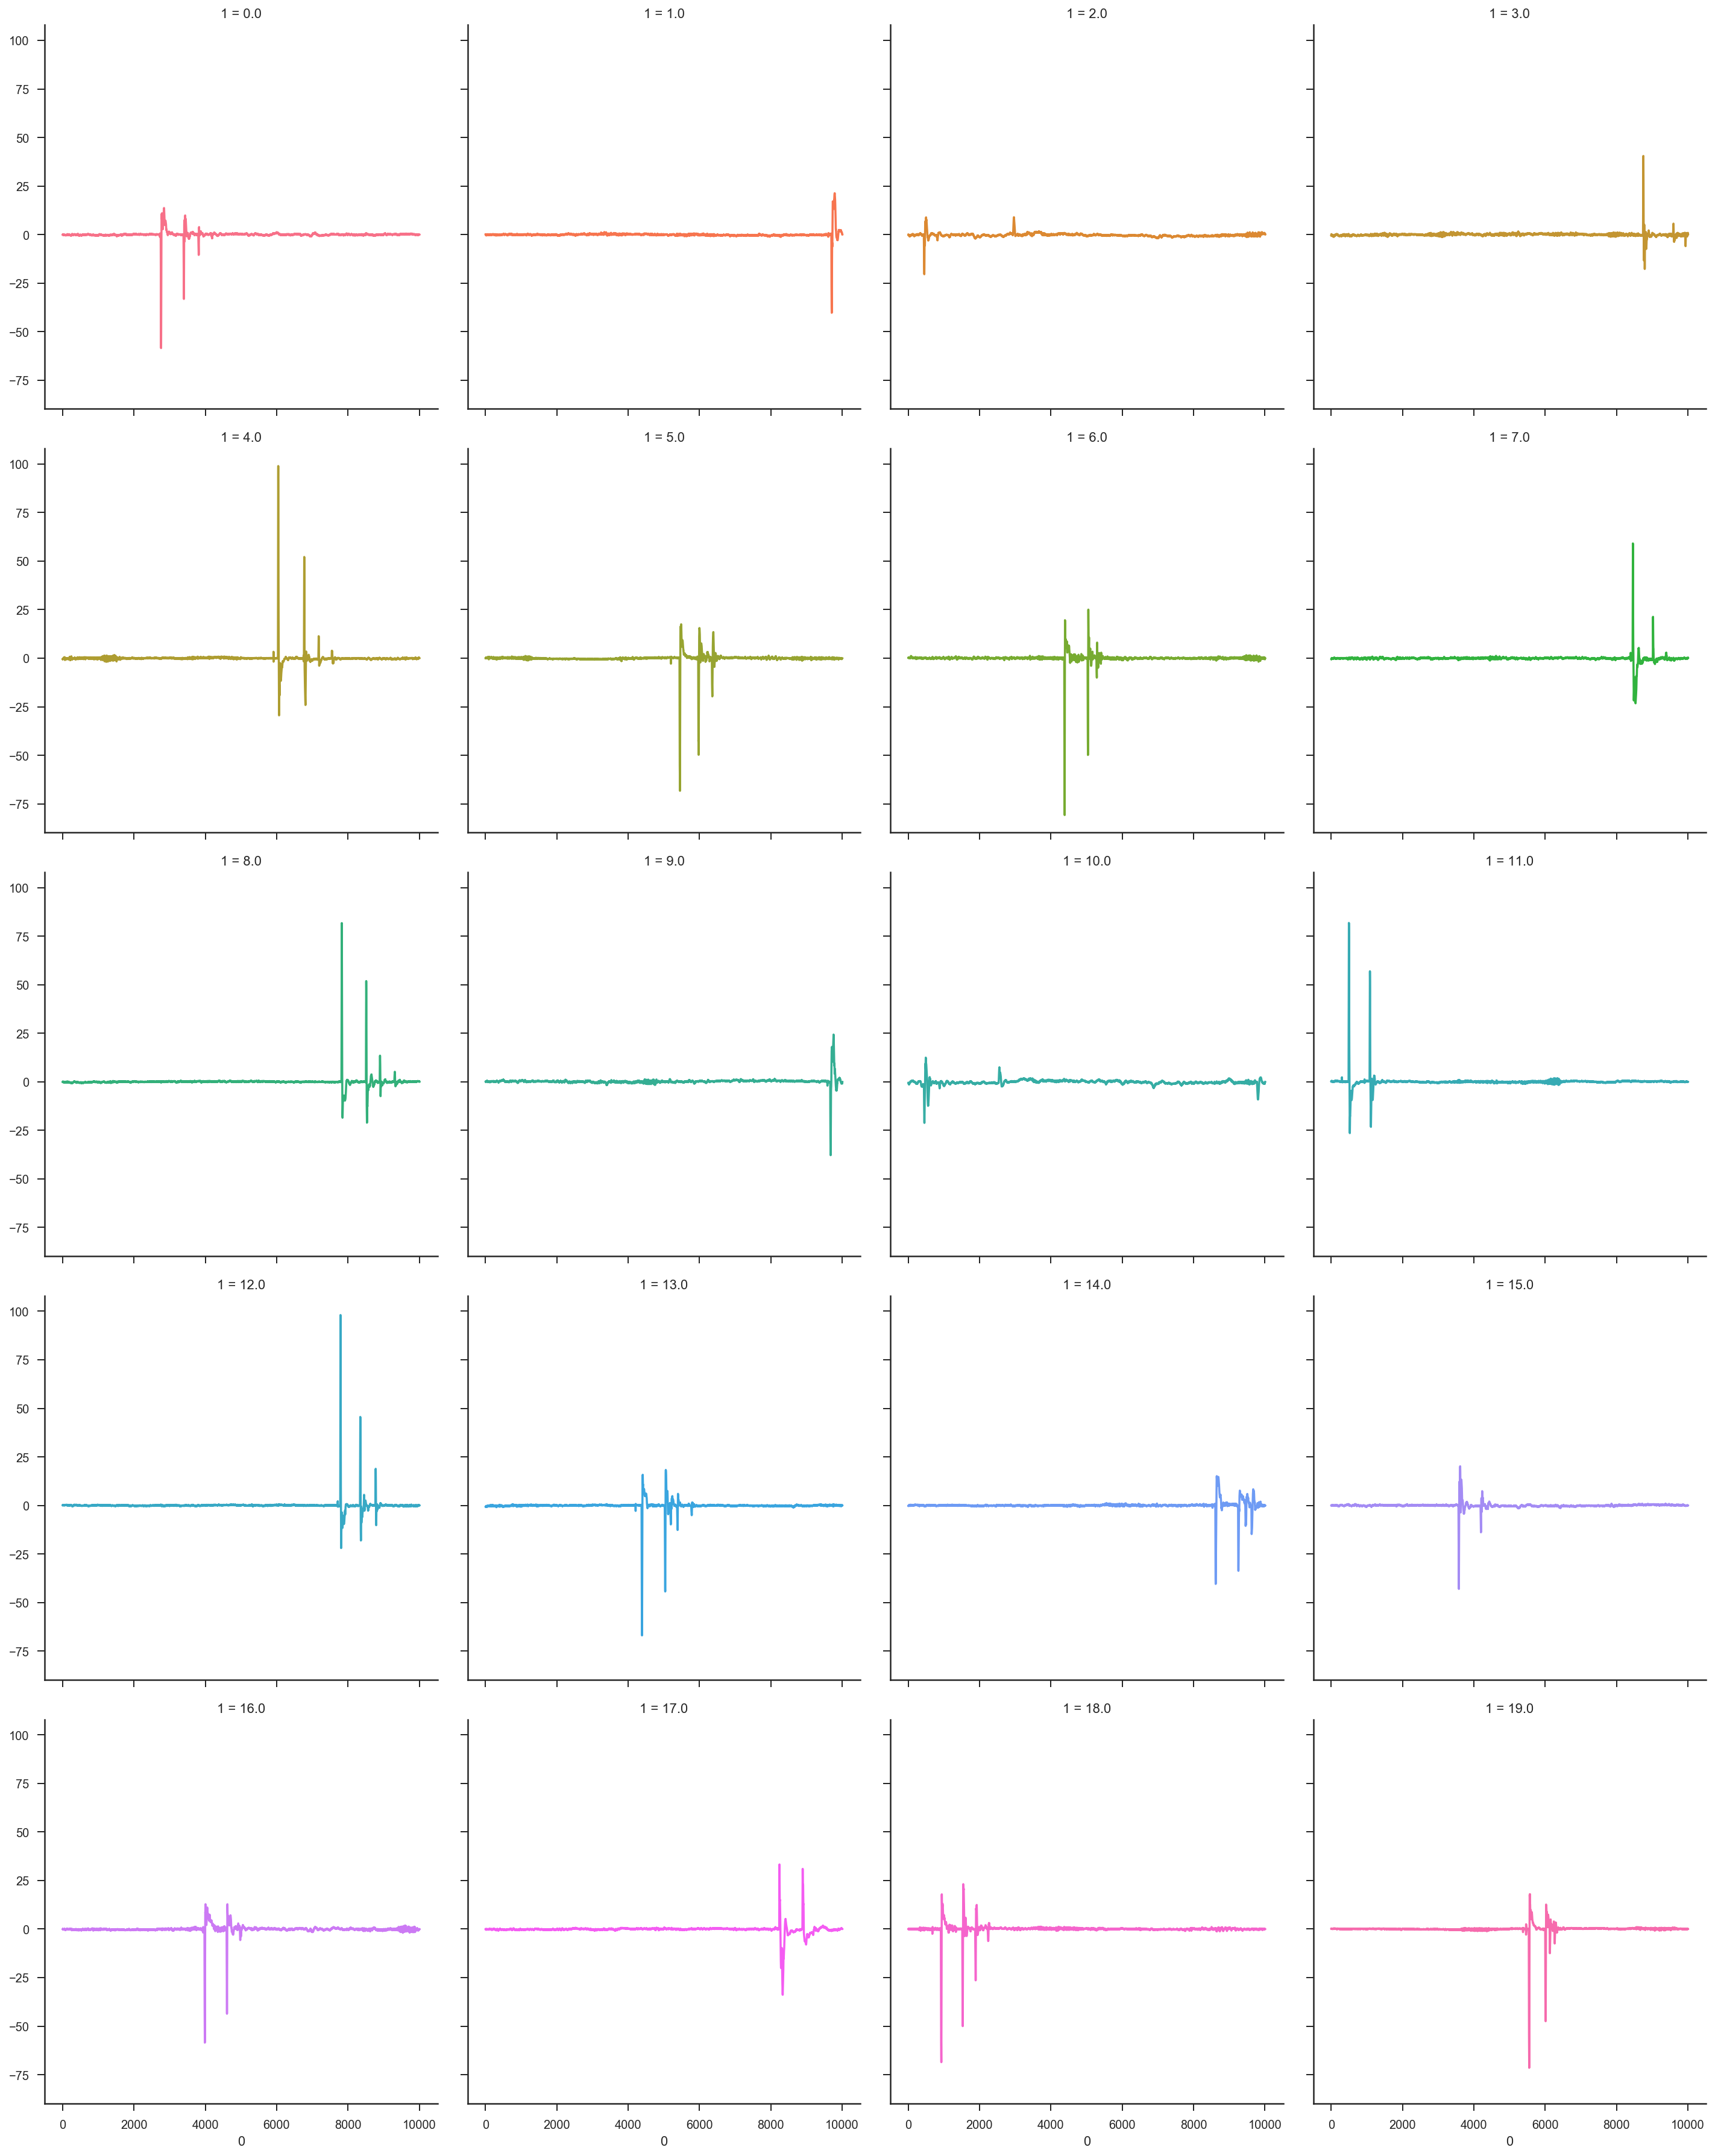

In [23]:
sns.set(style="ticks")

# Initialize a grid of plots with an Axes for each transient
grid = sns.FacetGrid(master_df, col=1, hue=1, col_wrap=4, size=5)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 0, ms=4)

In [ ]:
len(transients_2_phase)

In [ ]:
len(transients_3_phase)

### Create Feature Dataframe from exist features

The Problem with time series is, that they are high dimensional. Therefore it's important to extract features from this time series to reduce the dimensions of the data. So the next step is to preprocessing our data, that we can extract features from this Dataframe. We will create a Dataframe for the current/voltage signals.

## Feature for one phase events

In [ ]:
from CREATE_DF import *

In [ ]:
%time feature_df_with_nan_1 = create_feature_df(transients_1_phase)

In [ ]:
# sort df: The code put all NaN values in the last columns of the df
feature_df_with_nan_sort_1 = feature_df_with_nan_1.apply(squeeze_nan, axis=1)
feature_df_with_nan_sort_1.reset_index(level=0, inplace=True)

# get columns name an put them into a list
original_columns = feature_df_with_nan_sort_1.columns.tolist()
# Create new column names
new_columns = original_columns[:4] + original_columns[10:13] + original_columns[19:20] + original_columns[22:23]
# drop all columns with NaN
feature_df_1_phase = feature_df_with_nan_sort_1.dropna(axis=1)
feature_df_1_phase = feature_df_1_phase.apply(pd.to_numeric)
feature_df_1_phase.columns = new_columns

In [ ]:
feature_df_1_phase.to_csv("feature_df_1_phase.csv", columns = new_columns, index=None)

## Feature for two phase events

In [ ]:
%time feature_df_with_nan_2 = create_feature_df(transients_2_phase)

# sort df: The code put all NaN values in the last columns of the df
feature_df_with_nan_sort_2 = feature_df_with_nan_2.apply(squeeze_nan, axis=1)
feature_df_with_nan_sort_2.reset_index(level=0, inplace=True)
# get columns name an put them into a list
original_columns = feature_df_with_nan_sort_2.columns.tolist()
# Create new column names
new_columns = original_columns[:7] + original_columns[10:16] + original_columns[19:21] + original_columns[22:24]
# drop all columns with NaN
feature_df_2_phase = feature_df_with_nan_sort_2.dropna(axis=1)
feature_df_2_phase = feature_df_2_phase.apply(pd.to_numeric)
feature_df_2_phase.columns = new_columns

In [ ]:
feature_df_2_phase.to_csv("feature_df_2_phase.csv", columns = new_columns, index=None)

## Feature for three phase events

In [ ]:
%time feature_df_3_phase = create_feature_df(transients_3_phase)

In [ ]:
feature_df_3_phase.reset_index(level=0, inplace=True)

In [ ]:
feature_df_3_phase.head()

In [ ]:
feature_df_3_phase.to_csv("feature_df_3_phase.csv", index=None)

In [ ]:
test = pd.read_csv("feature_df_3_phase.csv")

In [ ]:
test.head()

# Spielen

In [ ]:
Z = linkage(feature_df, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(feature_df))
c

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=7,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

In [ ]:
# create trasient data frame
raw_signal_current = data["raw_signal_current"]
raw_signal_voltage = data["raw_signal_voltage"]

# create dataframes
# on row contains on time series
# column is time or dimension
df_raw_signal_current = pd.DataFrame([x for x in raw_signal_current])
df_raw_signal_voltage = pd.DataFrame([x for x in raw_signal_voltage])

In [ ]:
df_raw_signal_current.head(1)

In [ ]:
df_raw_signal_voltage.head(1)

### Clustering

### Extract Features Voltage (mit tsfresh)

Quelle Bild:
https://tsfresh.readthedocs.io/en/latest/_images/feature_extraction_process_20160815_mc_1.png

In [ ]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import FeatureExtractionSettings

extraction_settings = FeatureExtractionSettings()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

# transpose since tsfresh reads times series data column-wise, not row-wise
df_raw_signal_voltage_t = df_raw_signal_voltage.copy().transpose()
df_raw_signal_voltage_t_cut = df_raw_signal_voltage_t[:100]

print(df_raw_signal_voltage_t_cut.shape)
len(df_raw_signal_voltage_t_cut.columns)

In [ ]:
# rearrange voltage column-wise, not row-wise

master_df = pd.DataFrame(df_raw_signal_voltage_t_cut[0])
master_df['id'] = 0

bar = progressbar.ProgressBar()

with progressbar.ProgressBar(max_value=len(df_raw_signal_voltage_t_cut.columns)) as bar:
    for i in range(1,500): #len(df_raw_signal_voltage_t.columns)
        signal_df = pd.DataFrame(df_raw_signal_voltage_t_cut[i])
        signal_df['id'] = i
        master_df = pd.DataFrame(np.vstack([master_df, signal_df]))
        bar.update(i)

In [ ]:
master_df.shape

In [ ]:
new_master_df = master_df.dropna(how='any')
new_master_df.shape

In [ ]:
%time X = extract_features(new_master_df, column_id=1, feature_extraction_settings=extraction_settings)